# Approximate State Preparation using MPS Sequential Encoding
State preparation is the task of compiling a quantum statevector $|\psi\rangle$ to a quantum circuit. There've benn many approacehs by researches who have proposed different shcema for tackling this problem.  

This topic has been researched since the early 2000s, belows are summary  
* Exact encoding of arbitrary statevector: Amplitude encoding was proposed as the most efficient exact encoding approach to compile arbitrary statevector. It encodes a vector of $2^{N}$ elements oveer a quantum circuit with $N$ qubits and a depth of $2^N$ approximately. It requires exponential number of gates to encode such an data structure.
* Variational encoding of arbitrary statevector: since 2015, many researchers pivoted towards using QML to approximately encode statevectors. It is stochastic (no analytical decomposition like Amplitude encoding) and focuses on an iterative approach to gradually train a QNN to fit tot he target state's distribution. These approaches also have their own challenges, i.e., "orthogonality catastrophe". Orthogonality catastrophe in QML refers to a situation where a small change in the parameters of a quantum model causes the quantum state to change drastically, becoming almost completely different from the original state. This problem cuased more focus on the expressivity of the ansatzes proposed, and the training approach to avoid Barren Plateaus
* MPS encoding: First seen in 2008 and becoming prominently known with Ran's work in 2019, MPS became a massive success in approximate compilation of statevectors. The approach utilized MPS representation of dense tensors (aka the statevector) to reduce the number of parameters needed to represent the tensor form $2^N$ to $2N \chi^2 $ where $\chi$ is called the bond dimension and serves as a reduce the scaling from $O(2^N)$ to $O(N)$. This allowed the limitation imposed by exact encoding to be relaxed to $O(N)$ and provided a significant reduction in depth. However this approach yet again had challenges. MPS tackles entanglement in a 1D manner, meaning long-range entanglement (if q0 and qN are entangle, this is long-range, whereas q0 and q1 entagled would be considered short-range) had to be captured via deeper circuits. Additionally, Ran's approach required many layers to adequately encode certain types of states, and is known for beding very slow to converge, To tackle this, Rudolph et al published a work in 2022 which utilized Environment Tensor Updates to optimize the circuit produced by Ran and find the optimal parameters for the ciruit without changing depth. This solved the issue with Ran, and is considered SOTA as of writing thie notebook

# Ran's approach  
Rna's approach construct an MPS from the statevector we want to compile. To exactly encode the MPS, we don't need more than one layer, however, we would need $[log_2(\chi)]+1$ qubits for the tensors depending on their bond dimension. This leads to larget circuits and maeks it harder to transfer the circuits to hardware  

He proposed to truncate the bond dimension of the MPS to 2, and encode the truncated version to a circuit which would now only require 1 and 2 qubit gates. This approximately encodes the MPS. To improve the fidelity, we need to generate many layers. Below is the pseudocode borrowed from Rudolph et al. Ran generates a layer, applies its invers to the original MPS to "update" it ofr more accurately disentangle it(push it close to product state $|000...0\rangle$), and generates a new layer from the updated original MPS. We do so until we run out of layers, or reach close enough to product state  

Thus, and approximate encoding using an iterative disentangling approach.  
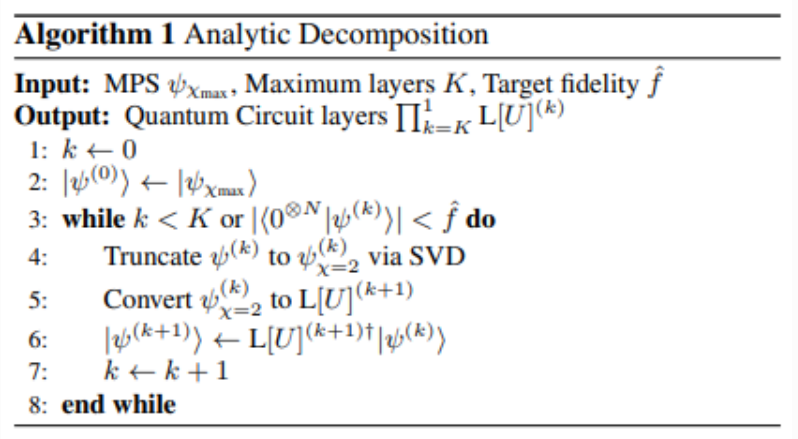

In [4]:
import numpy as np
from numpy.typing import NDArray
import cudaq
import quimb.tensor as qtn

In [5]:
def gram_schimidt(matrix: NDArray[np.complex128]) -> NDArray[np.complex128]:
    """Perform Gram-Schmidt orthonormalization on the columns of a matrix to define the unitary block to encode MPS."""
    
    "If a column is zero, replace it with a random vector before orthonormalization."

    """
    kwargs: matrix: input matrix with compelx entries
    returns: unitary: a matrix with orthonormal columns
    """
    
    n_rows, n_cols = matrix.shape
    unitary = np.zeros(size = (n_rows, n_cols), dtype = np.complex128)
    orthonormal_basis: list[NDArray[np.complex128]] = []

    for j in range(n_cols):
        col = matrix[:, j]

        if np.allclose(col, 0): # if the column is zero, replace it with a random vector
            col = np.random.uniform(-1, 1, n_rows)
            if np.iscomplexobj(matrix):
                col = col + 1j*np.random.uniform(-1, 1, n_rows)

        for basis_vec in orthonormal_basis:
            col -= (basis_vec.conj().T @ col) * basis_vec

        norm = np.linalg.norm(col) # handle near-zero vectors
        if norm < 1e-12: 
            is_complex = np.iscomplexobj(matrix)
            col = np.random.uniform(-1, 1, n_rows)
            if is_complex:
                col = col + 1j*np.random.uniform(-1, 1, n_rows)
            for basis_vec in orthonormal_basis:
                col -= (basis_vec.conj().T @ col) * basis_vec
        
        unitary[:, j] = col / np.linalg.norm(col)
        orthonormal_basis.append(unitary[:, j])
    
    return unitary

In [ ]:
class Sequential:
    def __init__(self, target_fidelity: float) -> None:
        self.target_fidelity = target_fidelity

    def generate_layer(self, mps: qtn.MatrixProductState) -> list[tuple[list[int], NDArray[np.complex128]]]:
        """ Convert a Matrix Product State (MPS) to a circuit representation using a single unitary layer


        Args: 
            mps: input MPS to be encoded

        Returns:
            unitary_layer: A list of tuples representing the unitary layer of the circuit.
            Each tuple contains
                - A list of qubit indices (in LSB order) that the unitary acts on
                - A unitary matrix (as a 2D NumPy array) that encodes the MPS.
        """

        num_sites = mps.L

        unitary_layer: list[tuple[list[int], NDArray[np.complex128]]] = []
        
        for i, tensor in enumerate(reversed(mps.arrays)):
            i = num_sites -i -1

            # MPS usese 1D entanglement, thus we need to define the range of the indices via the tensor shape
            # i.e., if q0 and q3 are entangled, then regardless of q1 and a2 being entangled the entanglement range would be q0-q3

            if i ==0:
                d_right, d = tensor.shape
                tensor = tensor.reshape((1, d_right, d))
            if i== num_sites-1:
                d_left, d = tensor.shape
                tensor = tensor.reshape((d_left, 1, d))
            tensor = np.swapaxes(tensor, 1, 2)




In [88]:
# Example:
import numpy as np

# Define a kernel that will produced the all |11...1> state.
kernel = cudaq.make_kernel()
qubits = kernel.qalloc(3)
# Prepare qubits in the 1-state.
kernel.x(qubits)

# Get the state of the system. This will execute the provided kernel
# and, depending on the selected target, will return the state as a
# vector or matrix.
state = cudaq.get_state(kernel)
print(state)

SV: [(0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (1,0)]



In [ ]:
noise_model = cudaq.NoiseModel()

@cudaq.kernel
def circuit():
    qv = cudaq.qvector(3)
    for i in range(3):
        rx(0, qv[i])

    cudaq.apply_noise(cudaq.BitFlipChannel, 0.5, qv[0])

# noise_model.add_channel('x', [0], cudaq.DepolarizationChannel(0.1))
    
# cudaq.observe(circuit, cudaq.spin.z(0), noise_model=noise_model)
cudaq.get_state(circuit, noise_model = noise).dump()

TypeError: get_state(): incompatible function arguments. The following argument types are supported:
    1. (arg0: object, *args) -> cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.State

Invoked with: <cudaq.kernel.kernel_decorator.PyKernelDecorator object at 0x7ff258241050>; kwargs: noise_model=<cudaq.mlir._mlir_libs._quakeDialects.cudaq_runtime.NoiseModel object at 0x7ff258242a30>

In [80]:
cudaq.get_state_async(circuit).get().dump()

[2025-11-28 14:57:48.917] [warning] apply_noise called but no noise model provided.
(1,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)



In [148]:
import cudaq

# Use the `nvidia` target
# Other targets capable of trajectory simulation are:
# - `tensornet`
# - `tensornet-mps`
# cudaq.set_target("nvidia")
cudaq.set_target("density-matrix-cpu")

# Let's define a simple kernel that we will add noise to.
qubit_count = 2


@cudaq.kernel
def kernel(qubit_count: int):
    qvector = cudaq.qvector(qubit_count)
    x(qvector)
    mz(qvector)


# Add a simple bit-flip noise channel to X gate
error_probability = 0.1
bit_flip = cudaq.BitFlipChannel(error_probability)

# Add noise channels to our noise model.
noise_model = cudaq.NoiseModel()
# Apply the bit-flip channel to any X-gate on any qubits
noise_model.add_all_qubit_channel("x", bit_flip)

# Due to the impact of noise, our measurements will no longer be uniformly
# in the |11> state.
noisy_counts = cudaq.sample(kernel,
                            qubit_count,
                            noise_model=noise_model,
                            shots_count=1000)

# The probability that we get the perfect result (11) should be ~ 0.9 * 0.9 = 0.81
noisy_counts.dump()

{ 00:12 01:102 10:92 11:794 }


In [ ]:
cudaq.get_state(kernel, 3).dump()

(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0)
(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (1,0)

